<a href="https://colab.research.google.com/github/bernarducs/code_chunks/blob/master/Projeto_S%C3%A9ries_Temporais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Detalhes do projeto

1 - Escolha uma ou duas bases de dados;

2 - Se necessário, faça um pré-processamento;
  - Analise as características da série temporal;
  - Utilize a Função de Auto-Correlação (FAC) e Função de Auto-Correlação Parcial (FACP)   

3 - Aplique um, ou dois métodos de previsão de série temporal:
  - Usar ARIMA, MLP e K-NN
  - Se escolher uma série temporal, utilize três métodos de previsão;
  - Se escolher duas série temporal, utilize dois métodos de previsão (ARIMA e MLP);

4 - Divida a série temporal em 50% treinamento, 25% validação e 25% teste para modelos de Machine Learning;
 - Divida a série temporal em 75% treinamento e 25% teste para o modelo ARIMA;

5 - Faça uma análise de sensibilidade dos parâmetros dos algoritmos utilizando o conjunto de validação (no caso das técnicas de Machine Learning);

6 - A partir da análise de sensibilidade, encontre os melhores parâmetros para cada método de previsão;

7 - Gere os resultados para o conjunto de teste;

8 - Compare os resultados a partir de duas, ou mais medidas de avaliação;
 - Sugestão: MSE, MAPE, POCID e MAE*

9 - Plote a previsão x série real

10 - Discuta qual o algoritmo que você escolheria para a base de dados analisada. 

OBS: Dividir o os dados em conjuntos de treinamento e teste, ou treinamento, validação e teste (se for necessário).

### Vehicle

Fonte: https://raw.githubusercontent.com/EraylsonGaldino/dataset_time_series/master/vehicle.txt

### Pacotes

In [ ]:
# dados
import numpy as np
import pandas as pd

In [ ]:
# visualização
import matplotlib.pyplot as plt
import seaborn as sns;

In [ ]:
# series temporais
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller  # teste de estacionariedade
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Preparação

### Dataset

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/EraylsonGaldino/dataset_time_series/master/vehicle.txt', names=['freq'])
df.head(3)

,freq
0,4.367
1,5.147
2,5.418


Temos 252 linhas no dataset. Como não sabemos as datas reais do dataset vamos arbitrar um intervalo temporal com intervalo de 252 períodos.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   freq    252 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


In [ ]:
df.index = pd.date_range(start='1/1/2000', periods=len(df))

In [ ]:
df.index.dtype

dtype('<M8[ns]')

### Características da Série

Plotando a série vemos que ela não é estacionária.

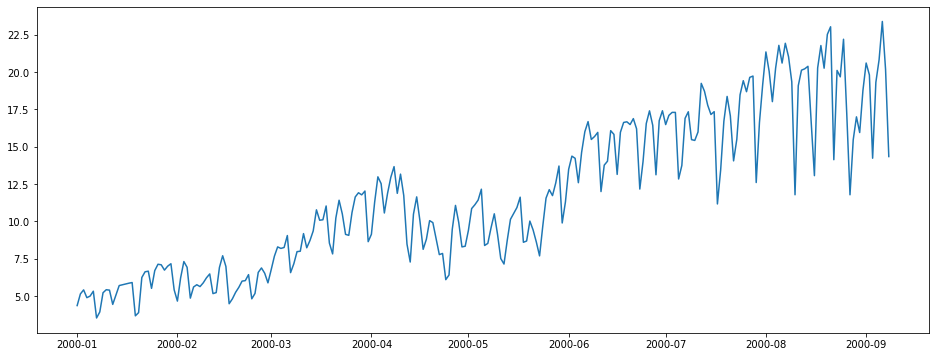

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(df);

Dando 'zoom' nos úlitmos 24 períodos para observar a presença de ciclos.

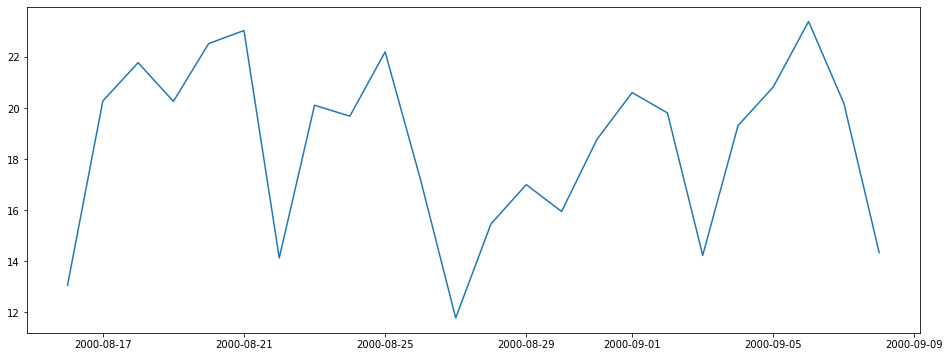

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(df.tail(24));

Usando *seasonal_decompose* do statsmodel fica mais clara a sazonalidade, com intervalo de 6 períodos.

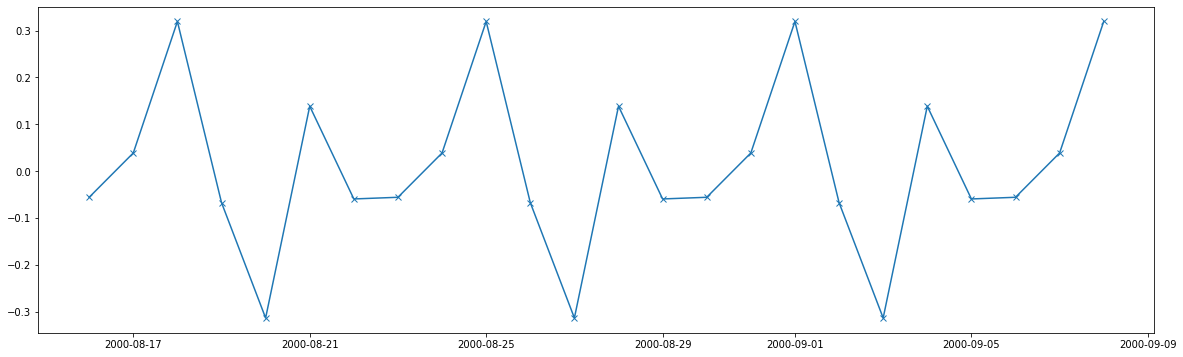

In [ ]:
plt.figure(figsize=(20, 6))
decomp = seasonal_decompose(df)
plt.plot(decomp.seasonal[-24:], 'x-');

Plotando todos os tipos de decomposição vemos também que a tendência e o ruído aumenta com o passar do tempo.

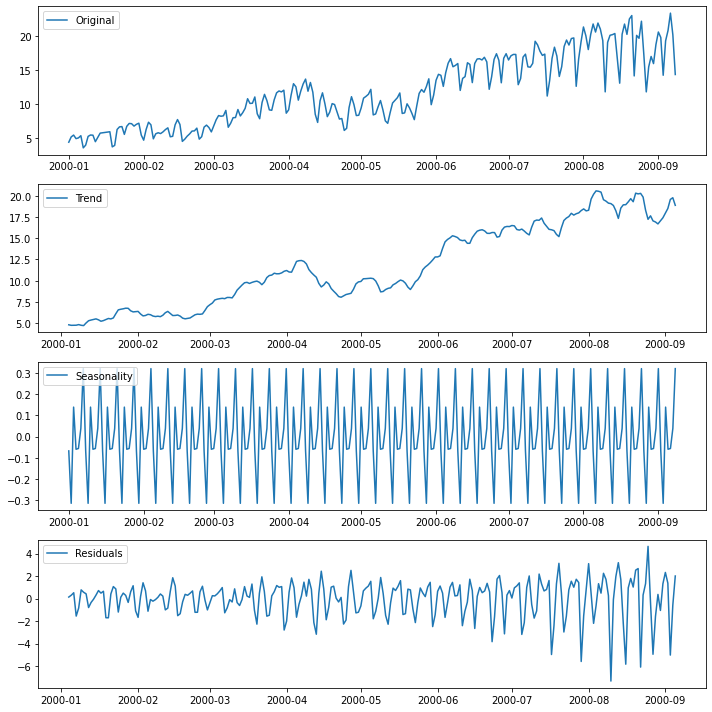

In [ ]:
tendencia = decomp.trend
sazonalidade = decomp.seasonal
residuo = decomp.resid

plt.figure(figsize=(10, 10))
plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(tendencia, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(sazonalidade,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residuo, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Treino e teste

In [ ]:
treino, teste = df[:-36], df[-36:]

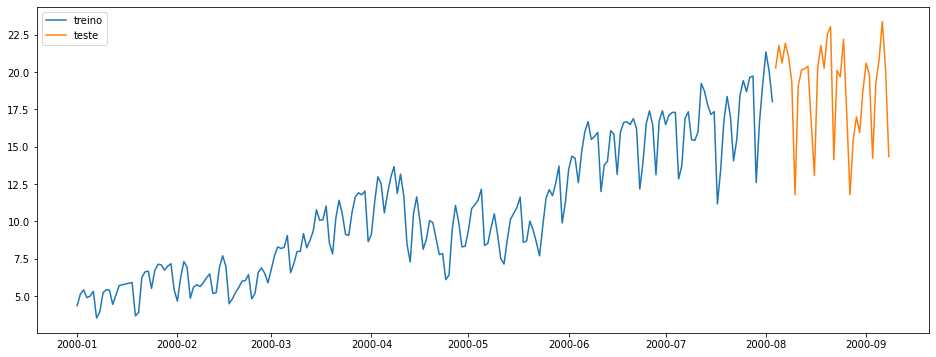

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(treino, label='treino')
plt.plot(teste, label = 'teste')
plt.legend(loc= 'best');

## ARIMA e SARIMAX

### Série estacionária

Já com os dados de treino vamos diferenciar nossa série em 6 períodos como identificamos logo acima.

In [ ]:
treino['6diff'] = treino.diff(6)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
def teste_df(serie, valor_critico=10):
    #H0: série não estacionária 
    dftest = adfuller(serie, autolag='AIC')
    df_output = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags','Nº Observações'])
    for key, value in dftest[4].items():
        df_output['Valor Crítico (%s)'%key] = value
    print(df_output)
    if df_output[0] < df_output[f"Valor Crítico ({valor_critico}%)"]: # descarta a H0 se o teste estatistico for menor que o valor crítico 
        
        print('--------estacionária')
    else:
        print(df_output[0])
        print('--------não estacionária')

Nossa diferenciação nos retornou estacionariedade com valor crítico de 5%.

In [ ]:
teste_df(treino['6diff'].dropna(), 5)

Test Statistic          -3.285130
p-value                  0.015556
#Lags                    8.000000
Nº Observações         201.000000
Valor Crítico (1%)      -3.463309
Valor Crítico (5%)      -2.876029
Valor Crítico (10%)     -2.574493
dtype: float64
--------estacionária


Mas não para 1%

In [ ]:
teste_df(treino['6diff'].dropna(), 1)

Test Statistic          -3.285130
p-value                  0.015556
#Lags                    8.000000
Nº Observações         201.000000
Valor Crítico (1%)      -3.463309
Valor Crítico (5%)      -2.876029
Valor Crítico (10%)     -2.574493
dtype: float64
-3.285129934116929
--------não estacionária


### Encontrando parâmetros para ARIMA

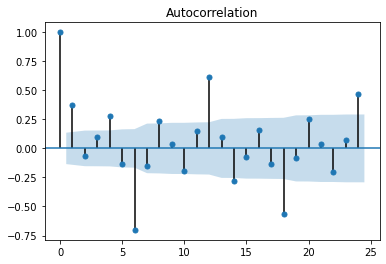

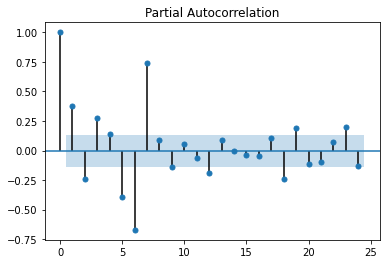

In [ ]:
plot_acf(treino['6diff'].dropna());
plot_pacf(treino['6diff'].dropna());

In [ ]:
arima_params = (2, 1, 1)

In [ ]:
model_arima = ARIMA(treino['freq'].values, order=arima_params).fit()

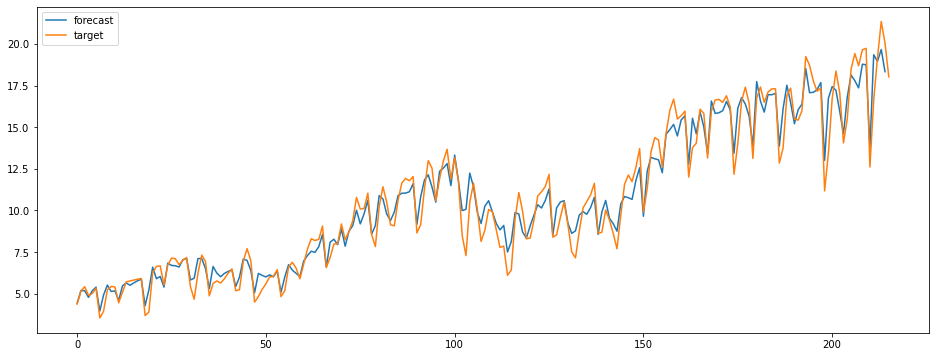

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(model_arima.predict(typ='levels'), label = 'forecast')
plt.plot(treino.freq.values, label = 'target')
plt.legend()
plt.show()

### Testando o modelo

In [ ]:
predito_arima = model_arima.predict(start=216, end=252, typ='levels')

In [ ]:
previsao_arima = model_arima.forecast(len(teste))

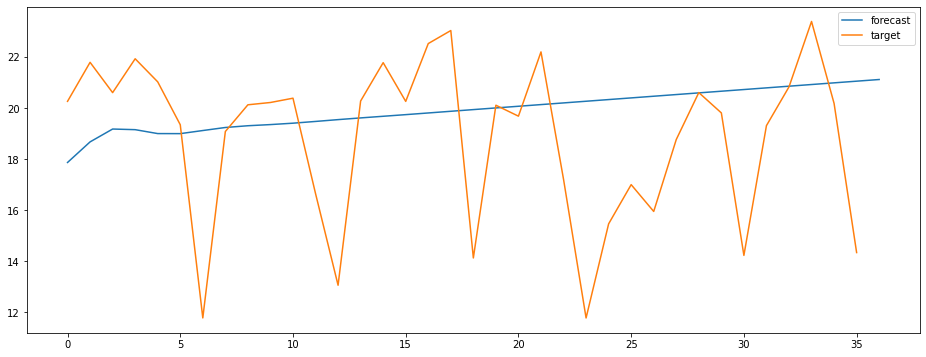

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(predito_arima, label = 'forecast')
plt.plot(teste.freq.values, label = 'target')
plt.legend()
plt.show()

In [ ]:
sarima_params = (*arima_params, 6)

In [ ]:
model_sarimax = SARIMAX(
    endog=treino['freq'].values, order=arima_params, seasonal_order=sarima_params).fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
previsao_sarima = model_sarimax.forecast(len(teste))

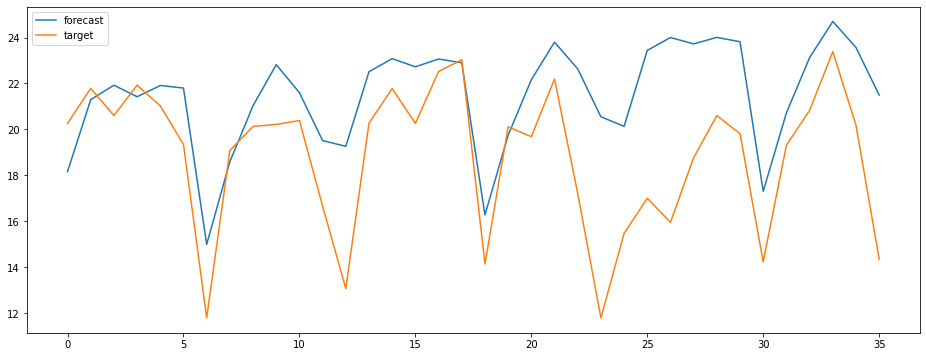

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(previsao_sarima, label = 'forecast')
plt.plot(teste.freq.values, label = 'target')
plt.legend()
plt.show()

## MLP